# RC Benchmarks

This notebook establishes all the available benchmarks for the FSPM reservoir evaluation framework.

In [2]:
import pandas as pd
import numpy as np
import sys, os

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../'))  # for importing local packages from src

%reload_ext autoreload
%autoreload 2 

### Loading test dataset

Will test on HydroShoot because it uses the multiple runs feature of the pipeline.

In [3]:
from src.model.rc_dataset import ExperimentDataset


DATASET_PATH = 'datasets/hydroshoot_large_trimmed.csv'

dataset = ExperimentDataset(csv_path=DATASET_PATH)

### Preparing test data

In [110]:
from pipeline_hydroshoot import (
  TargetGenerator,
  SingleReservoirGenerator,
  GroupGenerator,
)

from model_config_hydroshoot import targets, state_variables

# Defining dataset parameters for HydroShoot
datasets = (dataset,)
run_ids = dataset.get_run_ids()
np.random.seed(42)
state_ids = np.random.choice(dataset.state_size(), size=16, replace=False)

# Defining target and reservoir
target = targets[0]
state_var = state_variables[0]

# Generating test data
target_gen = TargetGenerator(target=target, run_ids=run_ids)
reservoir_gen = SingleReservoirGenerator(state_var=state_var, run_ids=run_ids, state_ids=state_ids)
group_gen = GroupGenerator(day_length=24, run_ids=run_ids, days_between_runs=1)

X_raw = reservoir_gen.transform(datasets) 
y_raw = target_gen.transform(datasets)
groups_raw = group_gen.transform(datasets)

print(X_raw.shape, y_raw.shape, groups_raw.shape)

(84, 168, 16) (84, 168) (84, 168)


## RC benchmark data transformers

### Signal delay line

delay=0, (84, 168) --> (84, 168)
delay=2, (84, 168) --> (84, 166)
delay=4, (84, 168) --> (84, 164)
delay=8, (84, 168) --> (84, 160)


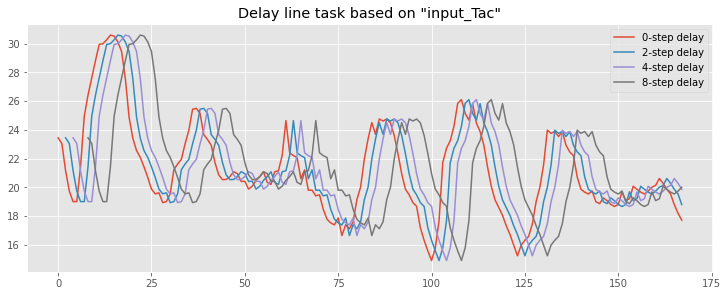

In [178]:
from pipeline_base import DelayLineTransform


delays = [0, 2, 4, 8]
delay_line_transforms = [DelayLineTransform(delay_steps=n) for n in delays]

tf_data = []
for delay, tf in zip(delays, delay_line_transforms):
  X, y, groups = tf.transform(X_raw, y_raw, groups_raw)
  print(f'{delay=}, {y_raw.shape} --> {y.shape}')
  tf_data.append((X, y, groups))


with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)

  for i in range(len(delays)):
    X, y, groups = tf_data[i]
    d = delays[i]
    plot_data = y[0]
    time = np.arange(len(plot_data)) + d
    ax.plot(time, plot_data, label=f'{d}-step delay')

  ax.legend()
  ax.set_title(f'Delay line task based on "{target}"')

### Polynomial transformation

coefs=(0, 1, 0, 16, 0, 3)


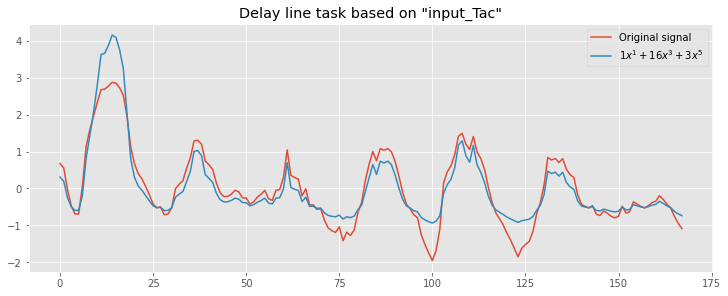

In [113]:
from pipeline_base import PolynomialTargetTransform
from sklearn.preprocessing import StandardScaler

coefs = [
  # [0] * 4 + [1],
  # [0] * 8 + [1],
  (0, 1, 0, 16, 0, 3),
]
poly_target_transforms = [PolynomialTargetTransform(poly_coefs=c) for c in coefs]

tf_data = []
for i, tf in enumerate(poly_target_transforms):
  X, y, groups = tf.transform(X_raw, y_raw, groups_raw)
  print(f'coefs={coefs[i]}')
  tf_data.append((X, y, groups))


with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
  scaler = StandardScaler()

  plot_data = y_raw[0]
  plot_data = scaler.fit_transform(plot_data[:, np.newaxis])
  ax.plot(plot_data, label=f'Original signal')


  def coefs_to_tex(coefs):
    terms = [f'{c}x^{{{i}}}' if i != 0 else f'{c}' for i, c in enumerate((coefs)) if c != 0]
    return f'${" + ".join(terms)}$'


  for i in range(len(coefs)):
    X, y, groups = tf_data[i]
    plot_data = y[0]
    plot_data = scaler.fit_transform(plot_data[:, np.newaxis])
    ax.plot(plot_data, label=f'{coefs_to_tex(coefs[i])}')

  ax.legend()
  ax.set_title(f'Delay line task based on "{target}"')

### NARMA transform

In [131]:
A = np.arange(16)

scale = 2
n = 8
offset = scale * n

print(A)
print(A[15:15-offset+1:-scale])



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[15 13 11  9  7  5  3  1]


n_value=2, (84, 168) --> (84, 166)
n_value=5, (84, 168) --> (84, 163)
n_value=10, (84, 168) --> (84, 158)
n_value=20, (84, 168) --> (84, 148)


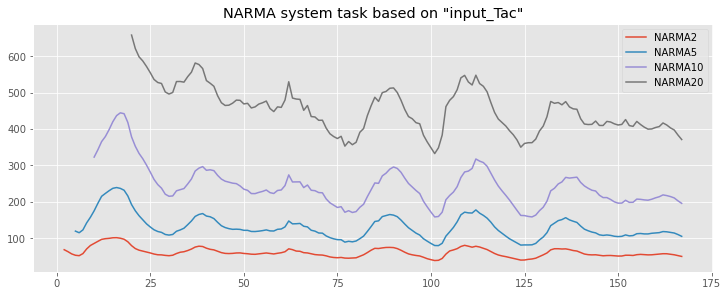

In [152]:
from pipeline_base import NarmaTargetTransform


n_values = [2, 5, 10, 20]
narma_transforms = [NarmaTargetTransform(n=n, scale=1) for n in n_values]

tf_data = []
for n_value, tf in zip(n_values, narma_transforms):
  X, y, groups = tf.transform(X_raw, y_raw, groups_raw)
  print(f'{n_value=}, {y_raw.shape} --> {y.shape}')
  tf_data.append((X, y, groups))


with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)

  for i in range(len(n_values)):
    X, y, groups = tf_data[i]
    n_value = n_values[i]
    plot_data = y[0]
    time = np.arange(len(plot_data)) + n_value
    ax.plot(time, plot_data, label=f'NARMA{n_value}')


  ax.legend()
  ax.set_title(f'NARMA system task based on "{target}"'),

### Future step prediction

delay=0, (84, 168) --> (84, 168)
delay=-2, (84, 168) --> (84, 166)
delay=-4, (84, 168) --> (84, 164)
delay=-8, (84, 168) --> (84, 160)


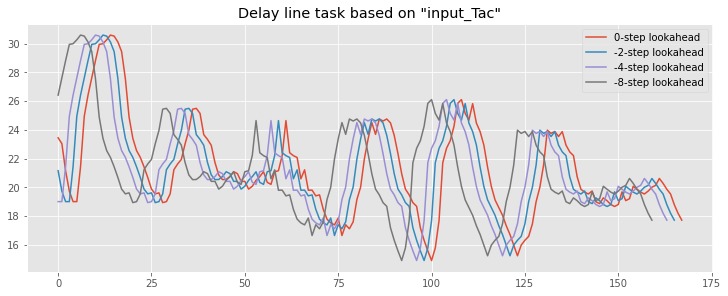

In [173]:
from pipeline_base import DelayLineTransform


delays = [0, -2, -4, -8]
delay_line_transforms = [DelayLineTransform(delay_steps=n) for n in delays]

tf_data = []
for delay, tf in zip(delays, delay_line_transforms):
  X, y, groups = tf.transform(X_raw, y_raw, groups_raw)
  print(f'{delay=}, {y_raw.shape} --> {y.shape}')
  tf_data.append((X, y, groups))


with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)

  for i in range(len(delays)):
    X, y, groups = tf_data[i]
    d = delays[i]
    plot_data = y[0]
    time = np.arange(len(plot_data))
    ax.plot(time, plot_data, label=f'{d}-step lookahead')
    # ax.plot(time + 2*d, X[0, :, 0], color='black', label='Reservoir')

  ax.legend()
  ax.set_title(f'Delay line task based on "{target}"')